# Marketing Mix Model
<B> Author:</B> Dominick Russo <br>
<B> email: </B> dominick.russo19@gmail.com<br>

Muma College of Business<br>
ISM6905: Integrative Project<br>
Master of Science, Business Analytics and Information Systems<br>
December 6, 2021

# Introduction
Advertisers use marketing mix models, also known as media mix models, to measure the effectiveness of various advertising channels on improving a metric [[1]](#Sources:), such as sales or return on investment (ROI). These models use time series data to model an outcome resulting from advertising variables, usually marketing or media spend [[1]](#Sources:). <Br>

The purpose of this project is to explore building a marketing mix model using simulated weekly marketing and sales data. The model will attempt to predict a change in sales volume based on changes in spend for TV and paid search advertisements.

# Data

The data for this model was generated using the Aggregate Marketing System Simulator (AMASS) [[4]](#Sources:), an open source R package provided by Google, Inc for research purposes. Code was obtained from [Google GitHub](https://github.com/google/amss/blob/master/vignettes/amss-vignette.Rmd) [[2]](#Sources:).

[R Code](https://github.com/deejayrusso/Marketing-Mix-Model/blob/main/Data%20Generation%20-%20AMSS.R)<br>
[Simulated Data](https://github.com/deejayrusso/Marketing-Mix-Model/blob/main/ObservedData.csv)

Variables used:<br>
* <b>tv.spend:</b> Weekly dollar spend on TV advertisement 
* <b>search.spend: </b> Weekly dollar spend on paid search advertisement
* <b>revenue: </b> Weekly dolllar sales

The AMASS was used to generate 208 rows representing 4 years of weekly data. The first 52 rows were dropped to allow the simulator time to normalize and produce more consistent data. The next 52 rows were dropped after feature engineering to remove null values produced after shifting data to create lag variables, leaving 104 rows representing 2 years. 

# Method

Ordinary least squares regressions, a polynomial regression, and multiple regularized regression models are explored to see which predicts sales based on tv and search advertising spend with the lowest error. 

<b>Steps and contents:</b>
1. Generate data and [load](#Load-Data) simulated data.<br>
2. [Explore data](#Explore-Data)
3. [Select features and target variable for models](#Select-features-and-target-variable-for-models)
4. [Feature engineering](#Feature-Engineering): Lag variables and rolling averages for marketing spend.
5. [Prepare data](#Prepare-data-for-pipeline) for model training and testing
6. [Create data pipeline](#Pipeline)
7. [Calculate baseline metrics](#Baseline)
8. Explore regression models
    * [Ordinary least squares](#Linear-Regression)
    * [Polynomial](#Polynomial-Regression)
    * [Lasso ](#Lasso-Regression)
    * [Ridge](#Ridge-Regression)
    * [Elastic net](#Elastic-Net)
    * [Stochastic gradient](#Stochastic-Gradient-Regressor)
9. [Compare models](#Model-Comparison) and [select best model](#Best-Model)
10. [Interpret findings](#Interpretation)

# Load Data

In [86]:
# Common imports
import pandas as pd
import numpy as np
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt

# Data prep imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# Model and evaluation imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor 
from sklearn.linear_model import RidgeCV

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Read data and set existing index as dataframe index

df = pd.read_csv('/Users/djdit/OneDrive - University of South Florida/Project/Marketing-Mix-Model/ObservedData.csv', 
                 index_col=[0])

In [3]:
# Check shape and top 5 rows

print(df.shape)
df.head()

(156, 17)


,time.index,tv.volume,tv.spend,search.clicks,search.imps,search.matching.query.volume,search.query.volume,search.spend,total.spend,brand.sales,competitor.sales,revenue,profit,tv.budget.index,tv.budget,search.budget.index,search.budget
1,53,0,0.000000e+00,0,0,3925234,17454556,0.0,0.000000e+00,1464929,8149405,117194320,1.171943e+08,2,47500000.0,2,12000000.0
2,54,1089276931,5.446534e+06,344738,4385017,4385017,19495548,379211.8,5.825746e+06,1824453,9169015,145956240,1.401305e+08,2,47500000.0,2,12000000.0
3,55,0,0.000000e+00,327228,4202279,4202279,18674739,359950.8,3.599508e+05,1593647,8850791,127491760,1.271318e+08,2,47500000.0,2,12000000.0
4,56,779008559,3.894953e+06,398409,5005803,5005803,22248392,438249.9,4.333203e+06,2109265,10658782,168741200,1.644080e+08,2,47500000.0,2,12000000.0
5,57,0,0.000000e+00,407746,5105357,5105357,22689299,448520.6,4.485206e+05,1983664,11031917,158693120,1.582446e+08,2,47500000.0,2,12000000.0


In [4]:
# Check data types

df.dtypes

time.index                        int64
tv.volume                         int64
tv.spend                        float64
search.clicks                     int64
search.imps                       int64
search.matching.query.volume      int64
search.query.volume               int64
search.spend                    float64
total.spend                     float64
brand.sales                       int64
competitor.sales                  int64
revenue                           int64
profit                          float64
tv.budget.index                   int64
tv.budget                       float64
search.budget.index               int64
search.budget                   float64
dtype: object

# Explore Data

In [5]:
# Check descriptive statistics

df.describe()

,time.index,tv.volume,tv.spend,search.clicks,search.imps,search.matching.query.volume,search.query.volume,search.spend,total.spend,brand.sales,competitor.sales,revenue,profit,tv.budget.index,tv.budget,search.budget.index,search.budget
count,156.000000,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,156.000000,1.560000e+02
mean,130.500000,1.730752e+08,8.653846e+05,315967.044872,4.207188e+06,4.969196e+06,1.470570e+07,347563.749359,1.212948e+06,1.241617e+06,6.668882e+06,9.932939e+07,9.811644e+07,3.000000,4.500000e+07,3.000000,1.800000e+07
std,45.177428,2.557752e+08,1.278889e+06,200596.569821,2.545892e+06,1.936581e+06,3.892745e+06,220656.226803,1.305055e+06,4.003445e+05,2.105946e+06,3.202756e+07,3.165117e+07,0.819126,2.280351e+06,0.819126,4.914757e+06
min,53.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.833205e+06,8.147354e+06,0.000000,0.000000e+00,5.613870e+05,3.118096e+06,4.491096e+07,4.489346e+07,2.000000,4.200000e+07,2.000000,1.200000e+07
25%,91.750000,0.000000e+00,0.000000e+00,193154.000000,2.711724e+06,3.671494e+06,1.112414e+07,212469.400000,3.280817e+05,8.767255e+05,4.745538e+06,7.013804e+07,6.919556e+07,2.000000,4.200000e+07,2.000000,1.200000e+07
50%,130.500000,0.000000e+00,0.000000e+00,321727.500000,4.207117e+06,4.628674e+06,1.438107e+07,353900.250000,5.835538e+05,1.205290e+06,6.478346e+06,9.642320e+07,9.546933e+07,3.000000,4.550000e+07,3.000000,1.800000e+07
75%,169.250000,3.030393e+08,1.515215e+06,437435.000000,5.718354e+06,6.191451e+06,1.791146e+07,481178.500000,1.924798e+06,1.560262e+06,8.412969e+06,1.248209e+08,1.225360e+08,4.000000,4.750000e+07,4.000000,2.400000e+07
max,208.000000,1.089277e+09,5.446534e+06,821813.000000,1.029838e+07,1.029838e+07,2.288058e+07,903994.300000,5.825746e+06,2.148049e+06,1.118451e+07,1.718439e+08,1.692871e+08,4.000000,4.750000e+07,4.000000,2.400000e+07


Weekly revenue ranges from $ \$ 44$ million to $ \$171$ million, with a mean of $ \$ 99$ million and standard deviation of $ \$ 32$ million.

tv.spend and search.spend both have minimum values of 0, indicating there are weeks where either or both of these advertising channels are turned off. The quartile values indicate search advertising spend is occuring at least 75% of the weeks while tv advertising spend is occuring 50% or less.

In [6]:
#Check for nulls

missing_data = df.isnull().sum()
missing_data

time.index                      0
tv.volume                       0
tv.spend                        0
search.clicks                   0
search.imps                     0
search.matching.query.volume    0
search.query.volume             0
search.spend                    0
total.spend                     0
brand.sales                     0
competitor.sales                0
revenue                         0
profit                          0
tv.budget.index                 0
tv.budget                       0
search.budget.index             0
search.budget                   0
dtype: int64

In [7]:
# Check unique values per column

df.nunique()

time.index                      156
tv.volume                        74
tv.spend                         74
search.clicks                   133
search.imps                     133
search.matching.query.volume    156
search.query.volume             156
search.spend                    133
total.spend                     144
brand.sales                     156
competitor.sales                156
revenue                         156
profit                          156
tv.budget.index                   3
tv.budget                         3
search.budget.index               3
search.budget                     3
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

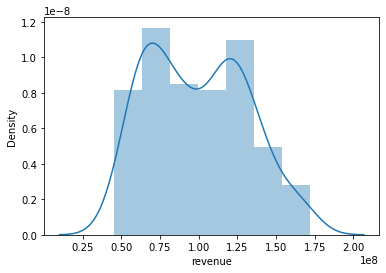

In [8]:
# See distribution of target variable

sns.distplot(df['revenue'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

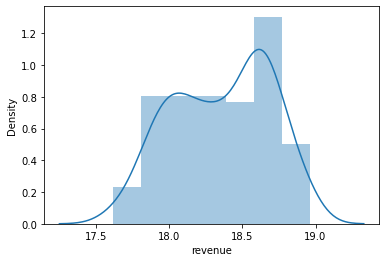

In [9]:
# Log transform of target variable

sns.distplot(df['revenue'].apply(np.log))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

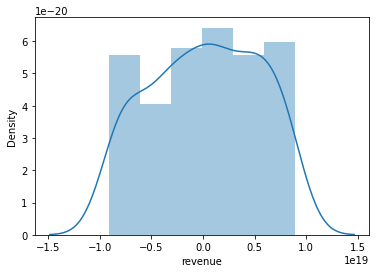

In [10]:
# Third order polynomial

sns.distplot(df['revenue']**3)

The distribution of the target variable seems somewhat normal but right skewed. Using a log transform did not make the distribution more normal, but using a 3rd order polynomial transofrmation did. The [Pipeline section](#Pipeline) will apply data transformations.

<AxesSubplot:>

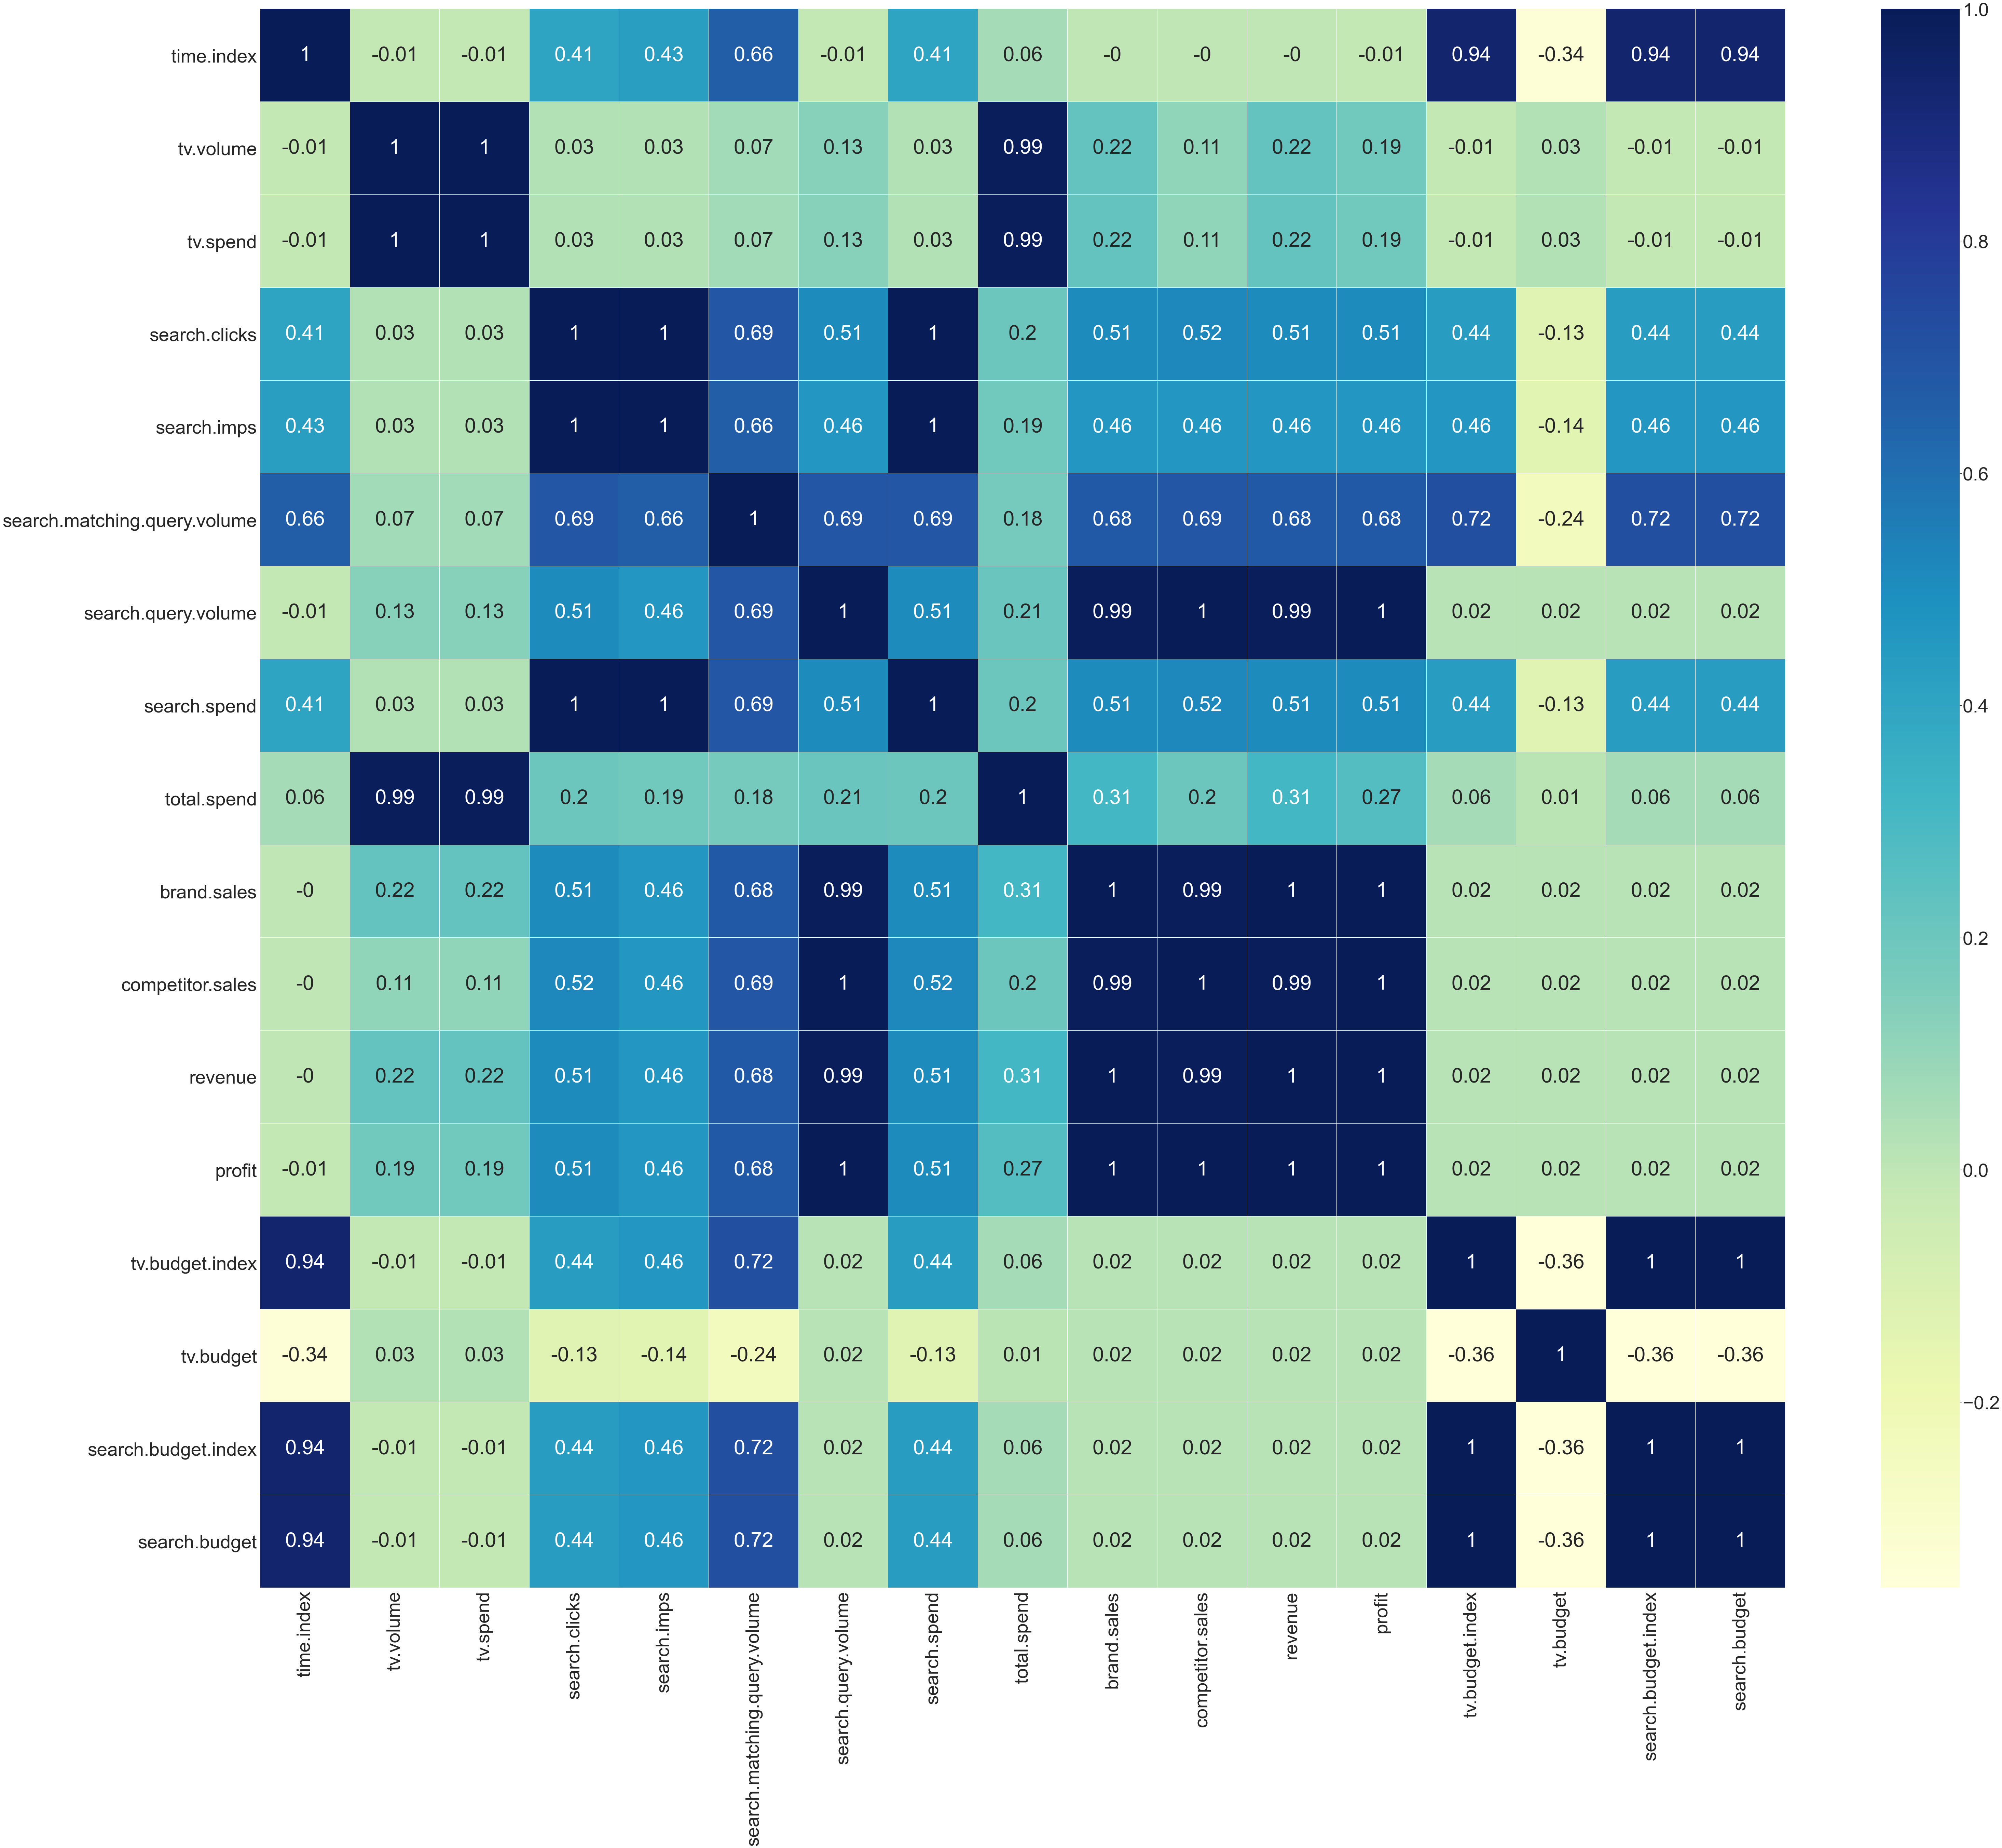

In [11]:
# Check correlation between variables

sales_corr = round(df.corr(),2)
sns.set(font_scale=5)
plt.subplots(figsize=(100,85))

sns.heatmap(sales_corr, cmap='YlGnBu', linewidth=.005, annot=True)

# Select features and target variable for models

These models will attempt to predict revenue based on tv and search advertising spend. We will select only the marketing spend variables and revenue to use.

In [12]:
# Create new data frame with variables intended to for use with models

sale_spend = df.loc[:, df.columns.intersection(['tv.spend', 'search.spend','revenue'])]

In [13]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(156, 3)


,tv.spend,search.spend,revenue
1,0.000000e+00,0.0,117194320
2,5.446534e+06,379211.8,145956240
3,0.000000e+00,359950.8,127491760
4,3.894953e+06,438249.9,168741200
5,0.000000e+00,448520.6,158693120


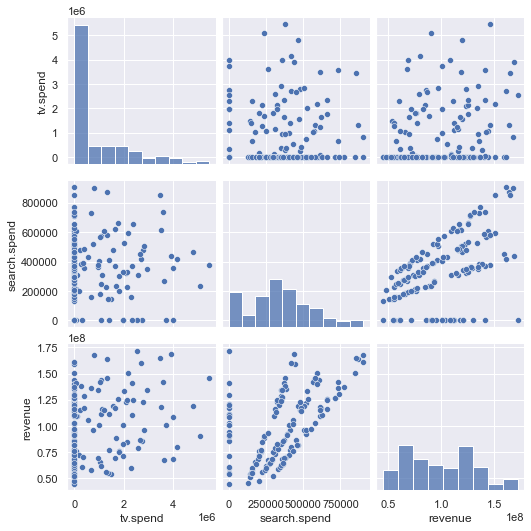

In [14]:
# Check distribution of variables and relation to each other

sns.set(font_scale=1)

sns.pairplot(sale_spend)

# Feature Engineering

Some new features will be created to account for seasonality and other trends:
* tv.spend, search.spend, and revenue are shifted 52 weeks to create one year lag variables (_lag1y) for seasonality.
* Revenue will also be shifted one week (_lag1w) and three months (lag3m) to explore effects of delayed purchase after interacting with an advertisement.
* To explore advertising trends, rolling averages for both tv.spend and search.spend are calculated for one week (_p1w), three months (_p3m) , and one year (_p1y).

In [15]:
# Create lag variables for 1y for revenue and channels to look for seasonality

sale_spend = pd.concat([sale_spend, sale_spend.shift(52).add_suffix('_lag1y')], axis=1)

sale_spend['revenue_lag1w'] = sale_spend['revenue'].shift()
sale_spend['revenue_lag3m'] = sale_spend['revenue'].shift(13)


In [16]:
# Create rolling average variable for 1y, 3m, and 1w for all channel spend 

sale_spend = pd.concat([sale_spend, sale_spend.rolling(1).mean().add_suffix('_p1w'), 
                        sale_spend.rolling(13).mean().add_suffix('_p3m'), 
                        sale_spend.rolling(52).mean().add_suffix('_p1y')], axis=1)

In [17]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(156, 32)


,tv.spend,search.spend,revenue,tv.spend_lag1y,search.spend_lag1y,revenue_lag1y,revenue_lag1w,revenue_lag3m,tv.spend_p1w,search.spend_p1w,...,revenue_lag1w_p3m,revenue_lag3m_p3m,tv.spend_p1y,search.spend_p1y,revenue_p1y,tv.spend_lag1y_p1y,search.spend_lag1y_p1y,revenue_lag1y_p1y,revenue_lag1w_p1y,revenue_lag3m_p1y
1,0.000000e+00,0.0,117194320,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.446534e+06,379211.8,145956240,NaN,NaN,NaN,117194320.0,NaN,5.446534e+06,379211.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000e+00,359950.8,127491760,NaN,NaN,NaN,145956240.0,NaN,0.000000e+00,359950.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.894953e+06,438249.9,168741200,NaN,NaN,NaN,127491760.0,NaN,3.894953e+06,438249.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000e+00,448520.6,158693120,NaN,NaN,NaN,168741200.0,NaN,0.000000e+00,448520.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# View data types

sale_spend.dtypes

tv.spend                  float64
search.spend              float64
revenue                     int64
tv.spend_lag1y            float64
search.spend_lag1y        float64
revenue_lag1y             float64
revenue_lag1w             float64
revenue_lag3m             float64
tv.spend_p1w              float64
search.spend_p1w          float64
revenue_p1w               float64
tv.spend_lag1y_p1w        float64
search.spend_lag1y_p1w    float64
revenue_lag1y_p1w         float64
revenue_lag1w_p1w         float64
revenue_lag3m_p1w         float64
tv.spend_p3m              float64
search.spend_p3m          float64
revenue_p3m               float64
tv.spend_lag1y_p3m        float64
search.spend_lag1y_p3m    float64
revenue_lag1y_p3m         float64
revenue_lag1w_p3m         float64
revenue_lag3m_p3m         float64
tv.spend_p1y              float64
search.spend_p1y          float64
revenue_p1y               float64
tv.spend_lag1y_p1y        float64
search.spend_lag1y_p1y    float64
revenue_lag1y_

In [19]:
# Drop extra columns generated from column shift and concatenation

sale_spend = sale_spend.loc[:, ~sale_spend.columns.duplicated()]
sale_spend.drop(['revenue_p1w', 'revenue_p3m', 'revenue_p1y'], axis=1, inplace=True)
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1y_p1w')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1y_p3m')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1y_p1y')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1w_p1w')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag3m_p1w')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1w_p3m')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag3m_p3m')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1w_p1y')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag3m_p1y')]

In [20]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(156, 14)


,tv.spend,search.spend,revenue,tv.spend_lag1y,search.spend_lag1y,revenue_lag1y,revenue_lag1w,revenue_lag3m,tv.spend_p1w,search.spend_p1w,tv.spend_p3m,search.spend_p3m,tv.spend_p1y,search.spend_p1y
1,0.000000e+00,0.0,117194320,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.0,NaN,NaN,NaN,NaN
2,5.446534e+06,379211.8,145956240,NaN,NaN,NaN,117194320.0,NaN,5.446534e+06,379211.8,NaN,NaN,NaN,NaN
3,0.000000e+00,359950.8,127491760,NaN,NaN,NaN,145956240.0,NaN,0.000000e+00,359950.8,NaN,NaN,NaN,NaN
4,3.894953e+06,438249.9,168741200,NaN,NaN,NaN,127491760.0,NaN,3.894953e+06,438249.9,NaN,NaN,NaN,NaN
5,0.000000e+00,448520.6,158693120,NaN,NaN,NaN,168741200.0,NaN,0.000000e+00,448520.6,NaN,NaN,NaN,NaN


In [21]:
#Check for nulls

missing_data = sale_spend.isnull().sum()
missing_data

tv.spend               0
search.spend           0
revenue                0
tv.spend_lag1y        52
search.spend_lag1y    52
revenue_lag1y         52
revenue_lag1w          1
revenue_lag3m         13
tv.spend_p1w           0
search.spend_p1w       0
tv.spend_p3m          12
search.spend_p3m      12
tv.spend_p1y          51
search.spend_p1y      51
dtype: int64

In [22]:
# Drop nulls

sale_spend = sale_spend.dropna()
sale_spend.shape

(104, 14)

<AxesSubplot:>

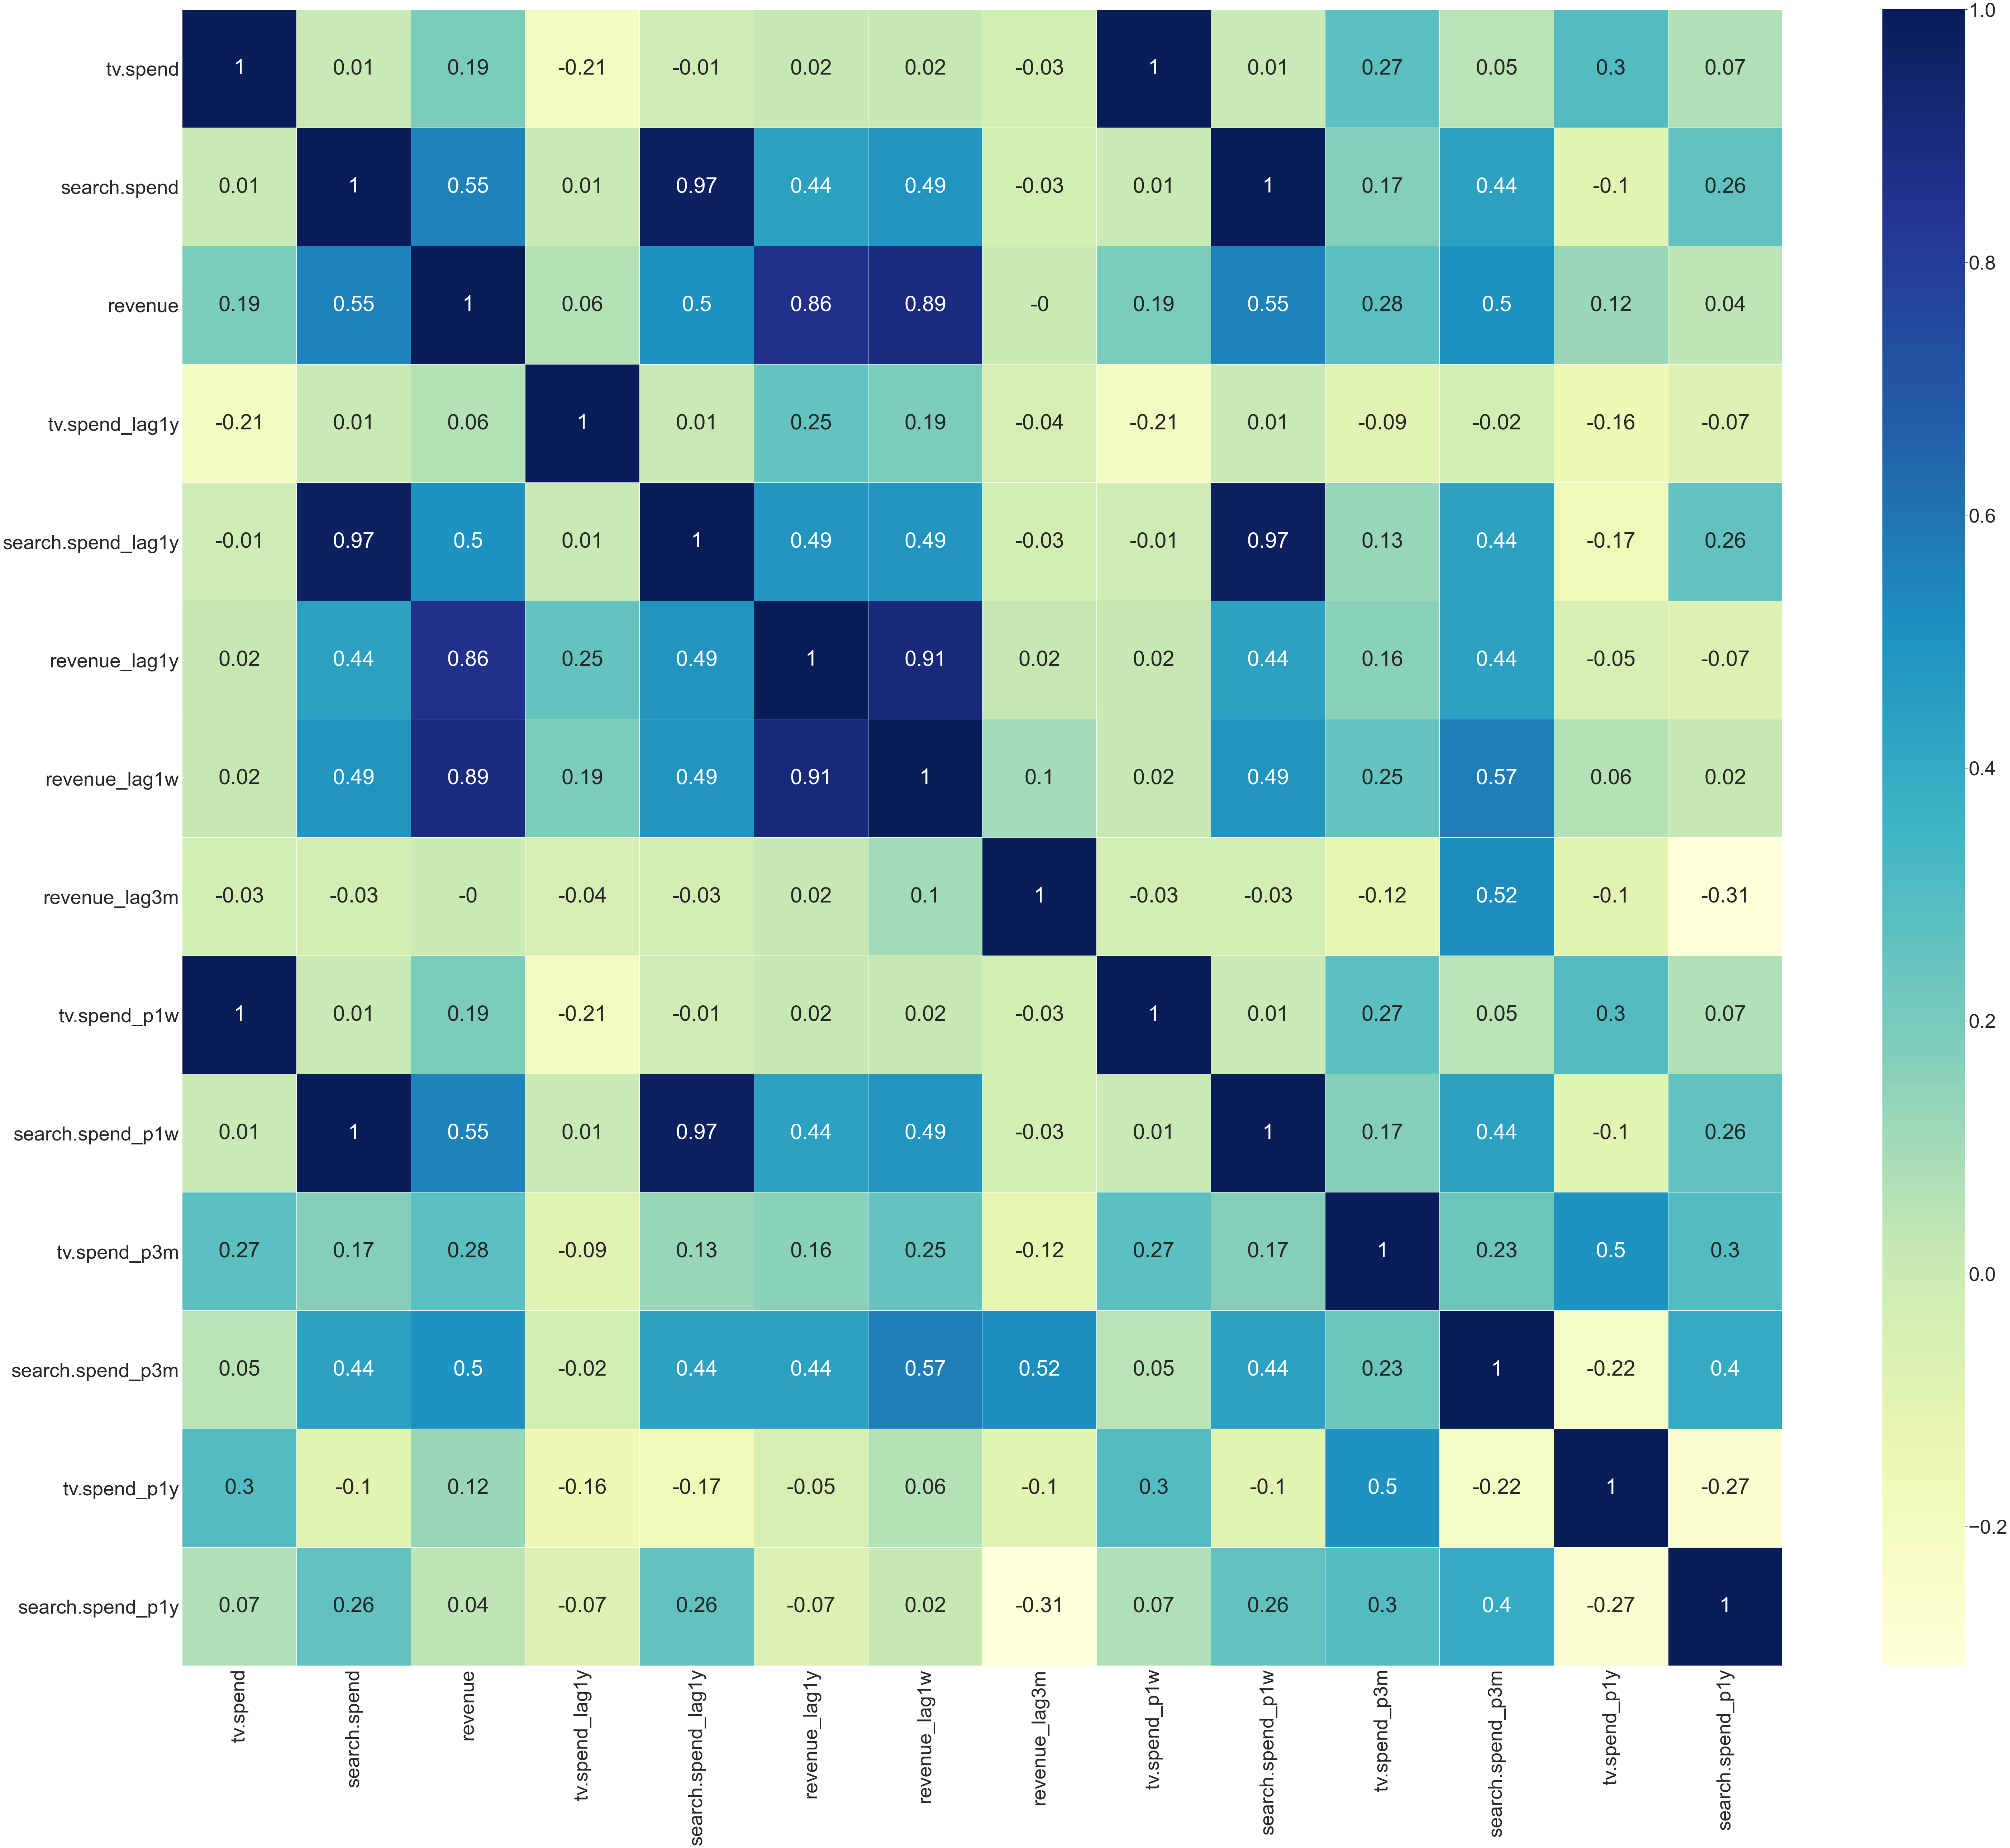

In [23]:
# Check correlation of new variables

sales_corr = round(sale_spend.corr(),2)
sns.set(font_scale=5)
plt.subplots(figsize=(100,85))

sns.heatmap(sales_corr, cmap='YlGnBu', linewidth=.005, annot=True)

tv.spend_p1w and search.spend_p1w are removed due to extremely high correlation. Other variable with correlation greater than 0.8 will remain as they could contribute information about seasonality, delayed purchase after an advertisement, or decaying interest after an advertisement.

In [24]:
# Remove '_p1w' variables due to high correlation (corr = 1).

sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_p1w')]

In [25]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(104, 12)


,tv.spend,search.spend,revenue,tv.spend_lag1y,search.spend_lag1y,revenue_lag1y,revenue_lag1w,revenue_lag3m,tv.spend_p3m,search.spend_p3m,tv.spend_p1y,search.spend_p1y
53,2.556818e+06,0.0,171843920,0.000000e+00,0.0,117194320.0,120768960.0,111486400.0,777932.265331,285979.946154,962631.108189,232345.363462
54,0.000000e+00,606416.8,143530400,5.446534e+06,379211.8,145956240.0,171843920.0,109101120.0,768112.356477,309056.169231,857890.068903,236714.690385
55,1.068467e+06,575487.0,143586160,0.000000e+00,359950.8,127491760.0,143530400.0,115684320.0,762469.913254,329523.530769,878437.501642,240859.617308
56,0.000000e+00,516824.0,122031200,3.894953e+06,438249.9,168741200.0,143586160.0,93143920.0,762469.913254,348965.946154,803534.552599,242370.657692
57,1.023443e+06,569357.8,142010400,0.000000e+00,448520.6,158693120.0,122031200.0,113742880.0,841196.277212,368035.038462,823216.143588,244694.450000


# Prepare data for pipeline

In [26]:
# Separate target and independant variables

y = sale_spend['revenue']
X = sale_spend.loc[:, sale_spend.columns != 'revenue']

In [27]:
# For each X, calculate VIF and save in dataframe

vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [28]:
# View VIF dataframe

vif.round(1)

,Features,VIF Factor
0,tv.spend,1.7
1,search.spend,74.7
2,tv.spend_lag1y,1.7
3,search.spend_lag1y,76.6
4,revenue_lag1y,79.1
5,revenue_lag1w,102.0
6,revenue_lag3m,43.5
7,tv.spend_p3m,23.0
8,search.spend_p3m,99.3
9,tv.spend_p1y,108.4


Most variables show very high VIF values, indicating a high degree of multicolinearity. This is expected given the interrelation of variables as well as new features.

In [29]:
# Create decision tree to help determine feature importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

<AxesSubplot:>

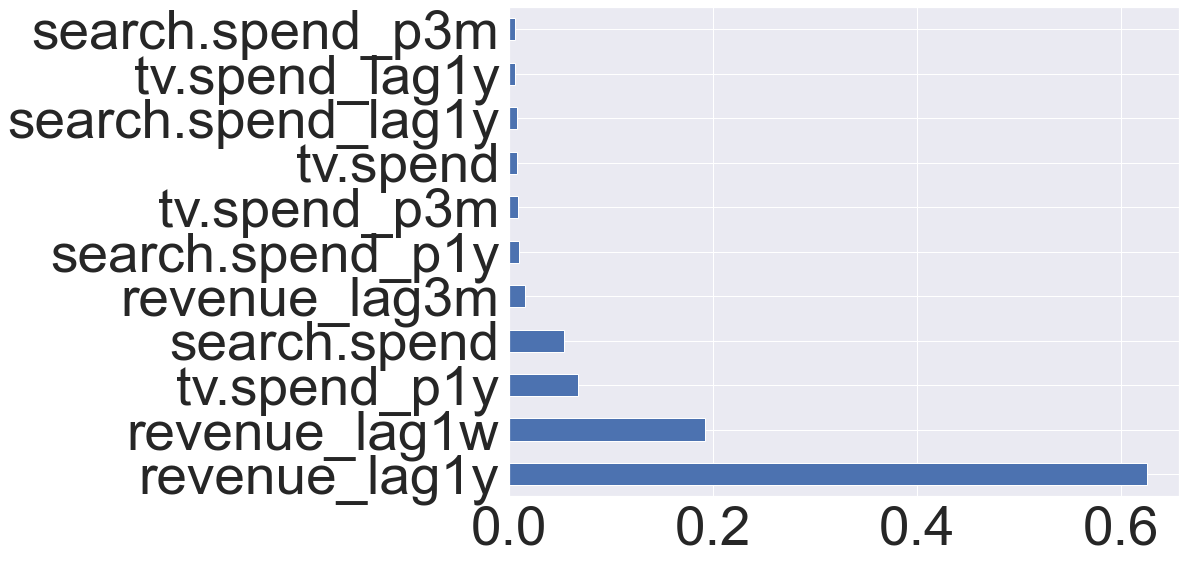

In [30]:
# Visualize feature importance based on decision tree

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(12,9))

revenue_lag1y seems to be the most important feature based on this decision tree, indicating seasonality could be a factor in weekly revenue. tv.spend may also be on a seasonal schedule. 

# Pipeline


In [31]:
# Make sure dataframes are compatible shapes

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(72, 11) (32, 11)
(72,) (32,)


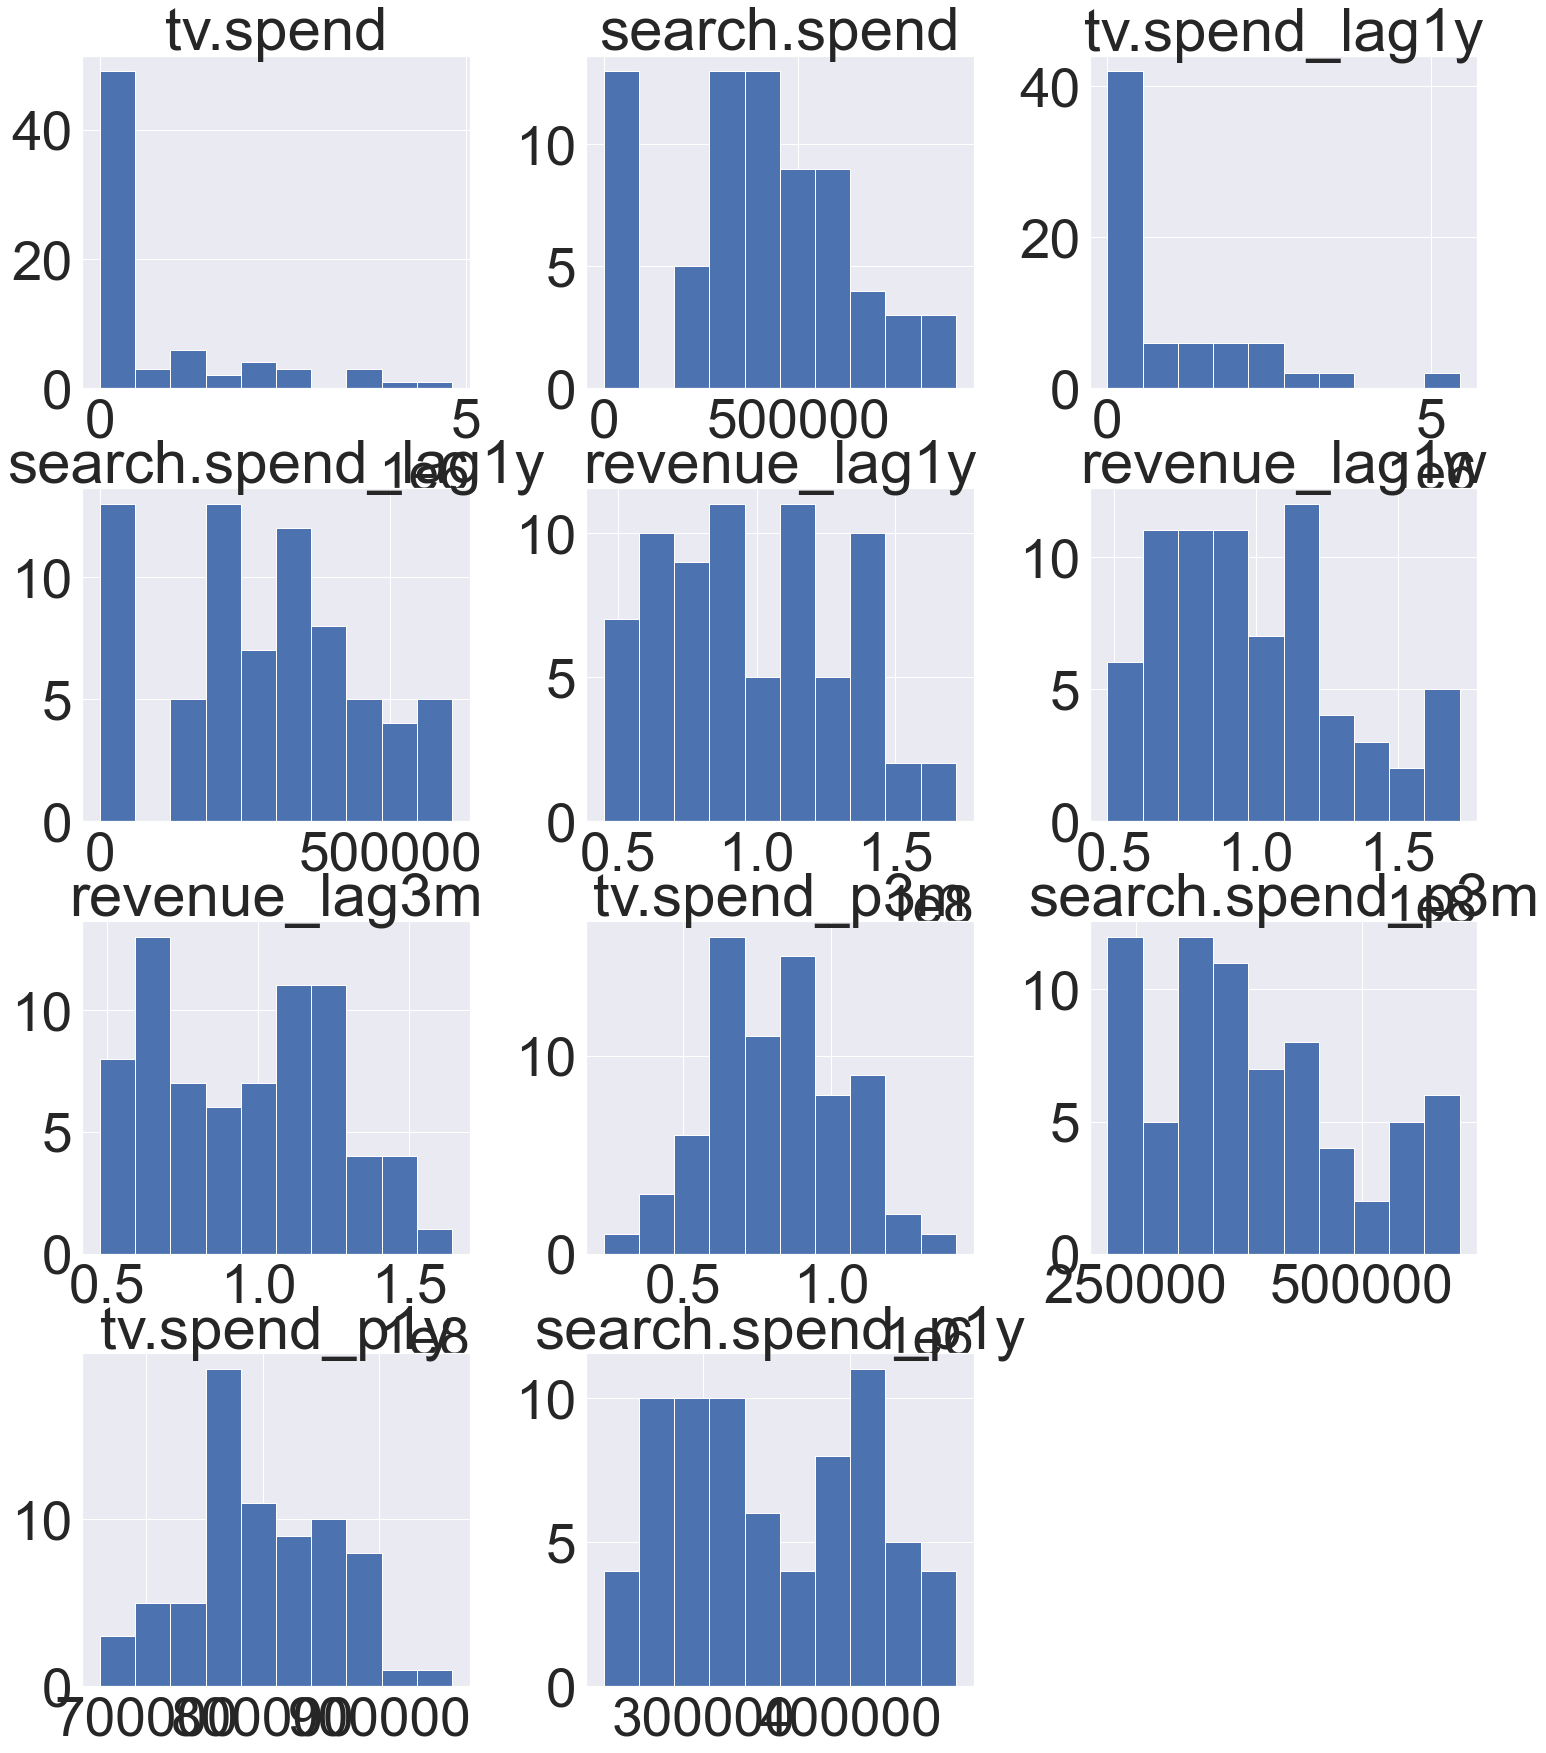

In [32]:
# View training feature distribution before transform 

X_train.hist(figsize=(25, 30))
plt.show()

In [33]:
scaler = StandardScaler()
distributor = PowerTransformer(method='yeo-johnson', standardize=False)

pipeline = Pipeline(steps=[
    ('scaler', scaler),    #scale numbers to same magnitude before normalizing distribution
    ('pt', distributor)    #transform numbers to more gaussian-like distribution
])

In [34]:
# Fit_transform train data with preprocessor

train_x = pipeline.fit_transform(X_train)

print(train_x.shape)
train_x

(72, 11)


array([[ 4.87392737e-01, -1.55209724e+00, -1.12248154e+00,
        -1.52469445e+00, -2.62029728e-01, -6.24433436e-01,
        -1.28741298e+00,  1.26511959e+00, -5.58835853e-01,
         8.53340366e-01,  1.09196191e+00],
       [-1.05320416e+00, -1.67974491e-01, -1.12248154e+00,
         4.59933775e-01, -5.15037192e-01, -1.07261570e+00,
         1.01082512e+00,  5.81080629e-01,  7.16525961e-01,
        -5.95054322e-01,  6.67787162e-01],
       [ 1.55887243e-03,  1.50872808e+00, -1.12248154e+00,
         2.00232103e+00,  1.26886382e+00,  6.18856293e-01,
         1.62545189e-01, -1.99713070e-01,  4.63160692e-01,
        -4.22060251e-01, -6.50645911e-02],
       [-1.05320416e+00, -5.85756130e-01,  6.22257948e-01,
        -6.53231234e-01, -1.31506997e+00, -1.02519379e+00,
        -4.30888130e-01, -6.77778112e-01, -1.37055327e+00,
         1.22839850e+00, -9.09079696e-01],
       [-1.05320416e+00, -8.53380905e-02, -8.21772210e-01,
        -4.11829885e-01, -8.83425158e-01, -2.19195340e-01,
  

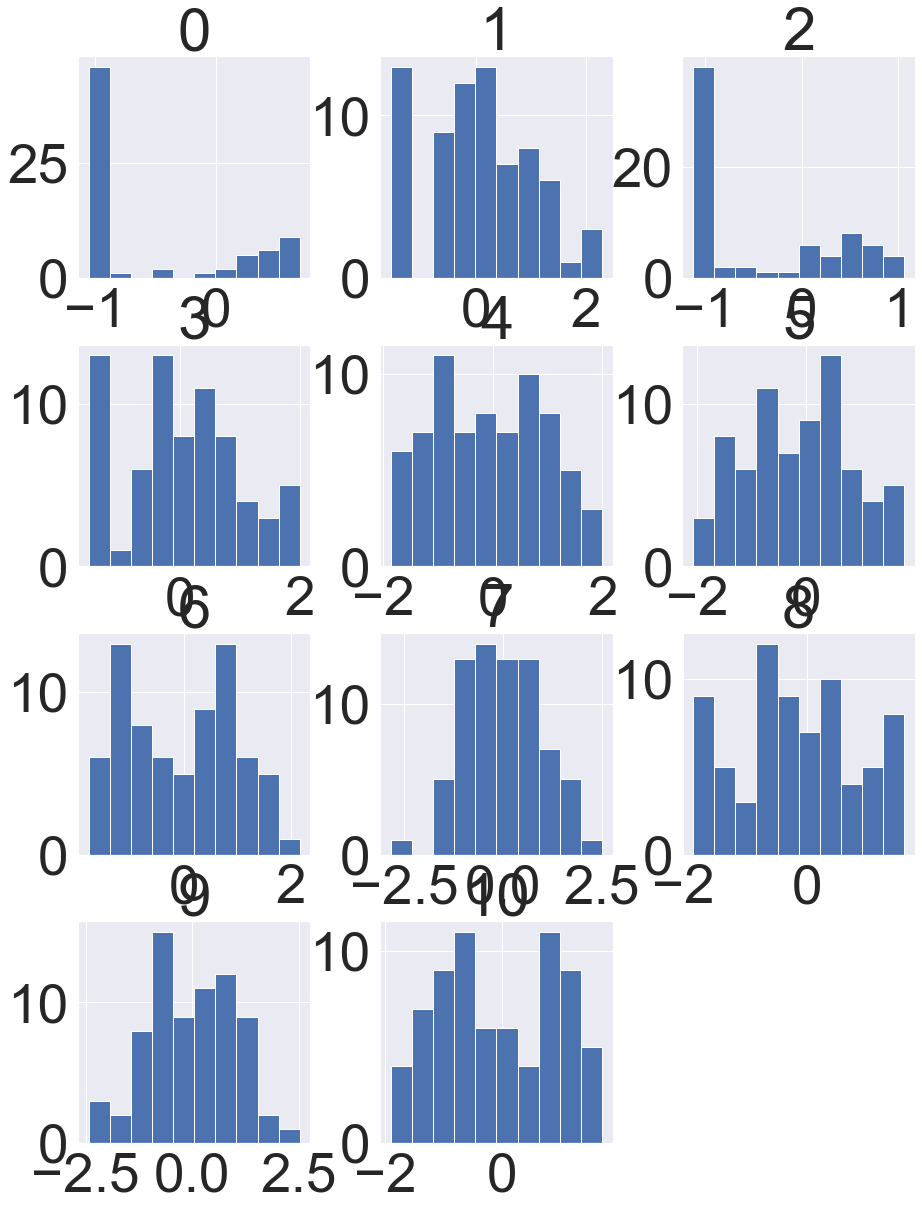

In [35]:
# View training feature distribution after transform 

train_x_df = pd.DataFrame(train_x)

train_x_df.hist(figsize=(15,20))
plt.show()

In [36]:
# Transform the test data

test_x = pipeline.transform(X_test)

print(test_x.shape)
test_x

(32, 11)


array([[ 0.48558952, -1.55209724, -1.12248154, -1.52469445, -1.3088071 ,
        -1.73602222,  0.16221891, -0.67777811, -1.26485974,  1.88688111,
        -0.93768453],
       [-1.05320416,  1.53062789, -1.12248154,  0.7934917 , -0.07925793,
         0.54116514,  1.76711165, -2.03538717,  1.44615777, -0.70529426,
         0.39976356],
       [ 0.24197809,  0.80208576, -1.12248154,  0.49936722,  0.83605622,
         1.18606705,  0.65730697, -0.24120209, -0.50506739,  1.28376028,
        -1.75396904],
       [ 0.63530567,  0.98101146, -1.12248154,  1.3936866 ,  0.61200233,
         0.88025337,  0.96743575, -0.71255798,  1.48414932,  0.42099912,
         0.42937521],
       [-1.05320416, -0.08833085,  0.69025976,  0.2152267 , -0.64014999,
        -1.09985228, -0.68886338, -1.33842906, -0.80414394, -1.34891903,
         0.97748629],
       [ 0.52121819,  0.8821448 , -1.12248154,  0.43739544,  0.72802527,
         0.94470964, -0.47873213,  0.23725528, -0.04129497,  0.13407045,
        -0.213

# Baseline

A baseline error is measured  by forecasting the mean weekly revenue for all predictions.

In [37]:
# Calculate mean revenue

mean_value = np.mean(y_train)

mean_value

98667211.1111111

In [38]:
# Predict all values as the mean

base_pred = np.repeat(mean_value, len(y_test))

base_pred

array([98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111, 98667211.1111111,
       98667211.1111111, 98667211.1111111])

In [39]:
# Calculate error to establish baseline measurements

base_mse = mean_squared_error(y_test, base_pred)

base_rmse = np.sqrt(base_mse)
base_mape = mean_absolute_percentage_error(y_test, base_pred)
base_r_sq = r2_score(y_test, base_pred)

print('Baseline RMSE: {}' .format(base_rmse))
print('Baseline MAPE: {}' .format(base_mape))
print('Baseline R2: {}' .format(base_r_sq))

Baseline RMSE: 32350200.101869214
Baseline MAPE: 0.3080689065045069
Baseline R2: -0.005206233767016011


# Linear Regression

The first model is an ordinary least squares (OLS) regression with all original variables.

In [40]:
# Split original dataframe to train/test

y_all = df['revenue']
x_all = df.loc[:, df.columns != 'revenue']


x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x_all, y_all, test_size=.3, random_state=0)

In [41]:
# Kitchen sink linear regression model from original dataframe 

lr_model = LinearRegression()

lr_model.fit(x_train_all, y_train_all)

LinearRegression()

In [42]:
#Train RMSE

reg_train_pred = lr_model.predict(x_train_all)

lr_train_mse = mean_squared_error(y_train_all, reg_train_pred)
lr_train_rmse = np.sqrt(mean_squared_error (y_train_all, reg_train_pred))

lr_train_mape = mean_absolute_percentage_error(y_train_all, reg_train_pred)
lr_train_r_sq = r2_score(y_train_all, reg_train_pred)

print('Train RMSE: {}' .format(lr_train_rmse))
print('Train MAPE: {}' .format(lr_train_mape))
print('Train R2: {}' .format(lr_train_r_sq))

Train RMSE: 1.9369406239340813e-07
Train MAPE: 1.4984138783244515e-15
Train R2: 1.0


In [43]:
#Test RMSE

reg_test_pred = lr_model.predict(x_test_all)

lr_test_mse = mean_squared_error (y_test_all, reg_test_pred)

lr_test_rmse = np.sqrt(mean_squared_error (y_test_all, reg_test_pred))
lr_test_mape = mean_absolute_percentage_error(y_test_all, reg_test_pred)
lr_test_r_sq = r2_score(y_test_all, reg_test_pred)


print('Test RMSE: {}' .format(lr_test_rmse))
print('Test MAPE: {}' .format(lr_test_mape))
print('Test R2: {}' .format(lr_test_r_sq))

Test RMSE: 1.8287617937923665e-07
Test MAPE: 1.4899712748034997e-15
Test R2: 1.0


<b>Impression: </b>R2 is incredibly high while RMSE and MAPE are incredibly low. The "kitchen sink" model is most likely overfit and not a good choice.

# Linear Regression Simplified

A simplified OLS regression will also be done to guage how well using only tv.spend and search.spend can predict revenue.

In [44]:
# Create train/ test variables using only two features: tv.spend and search.spend

y_simple = df['revenue']
x_simple = df[['tv.spend','search.spend']]


x_train_simple, x_test_simple, y_train_simple, y_test_simple = train_test_split(x_simple, y_simple, test_size=.3, random_state=0)

In [45]:
# Fit previously instantiated LR model on simplified data

lr_model.fit(x_train_simple, y_train_simple)

LinearRegression()

In [46]:
#Train RMSE

reg_train_pred = lr_model.predict(x_train_simple)

lrsimp_train_mse = mean_squared_error(y_train_simple, reg_train_pred)
lrsimp_train_rmse = np.sqrt(mean_squared_error (y_train_simple, reg_train_pred))
lrsimp_train_mape = mean_absolute_percentage_error(y_train_simple, reg_train_pred)
lrsimp_train_r_sq = r2_score(y_train_simple, reg_train_pred)

print('Train RMSE: {}' .format(lrsimp_train_rmse))
print('Train MAPE: {}' .format(lrsimp_train_mape))
print('Train R2: {}' .format(lrsimp_train_r_sq))

Train RMSE: 28011177.31739186
Train MAPE: 0.27290727089046724
Train R2: 0.2545513260172918


In [47]:
#Test RMSE

reg_test_pred = lr_model.predict(x_test_simple)

lrsimp_test_mse = mean_squared_error(y_test_simple, reg_test_pred)
lrsimp_test_rmse = np.sqrt(mean_squared_error (y_test_simple, reg_test_pred))
lrsimp_test_mape = mean_absolute_percentage_error(y_test_simple, reg_test_pred)
lrsimp_test_r_sq = r2_score(y_test_simple, reg_test_pred)

print('test RMSE: {}' .format(lrsimp_test_rmse))
print('test MAPE: {}' .format(lrsimp_test_mape))
print('test R2: {}' .format(lrsimp_test_r_sq))

test RMSE: 23300652.96250886
test MAPE: 0.24155755186895217
test R2: 0.4233070244876658


<b>Impression: </b>R2 is very low while RMSE and MAPE are not greatly improved over the baseline. The simplified model with only two predictor variables is insufficient as it shows signs of underfitting.

# Linear Regression with lag variables

Next, another OLS regression is done this time only using tv.spend, search.spend, and the engineered features (lag and rolling average variables).

In [48]:
# Linear model - spend and lag/rolling avg variables

lr_lagmodel = LinearRegression()

lr_lagmodel.fit(train_x, y_train)

LinearRegression()

In [49]:
#Train RMSE

reg_train_pred = lr_lagmodel.predict(train_x)

lrlag_train_mse = mean_squared_error(y_train, reg_train_pred)
lrlag_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
lrlag_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
lrlag_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(lrlag_train_rmse))
print('Train MAPE: {}' .format(lrlag_train_mape))
print('Train R2: {}' .format(lrlag_train_r_sq))

Train RMSE: 7582032.875849637
Train MAPE: 0.0515058420916952
Train R2: 0.9391150676633852


In [50]:
#Test RMSE

reg_test_pred = lr_lagmodel.predict(test_x)

lrlag_test_mse = mean_squared_error (y_test, reg_test_pred)
lrlag_test_rmse = np.sqrt(mean_squared_error (y_test, reg_test_pred))
lrlag_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
lrlag_test_r_sq = r2_score(y_test, reg_test_pred)


print('Test RMSE: {}' .format(lrlag_test_rmse))
print('Test MAPE: {}' .format(lrlag_test_mape))
print('Test R2: {}' .format(lrlag_test_r_sq))

Test RMSE: 7071079.569844888
Test MAPE: 0.054165981814058364
Test R2: 0.9519744132901219


<b>Impression:</b> RMSE and MAPE are greatly improved over baseline using selected features. The model does not show signs of overfitting.

# Polynomial Regression

A third degree polynomial transformation is done on the features to see if it decreases error since a third degree polynomial transformation seemed to normalize the distribution of the target variable. 

In [51]:
# Create third degree terms and interaction terms

poly_features = PolynomialFeatures(degree=3).fit(train_x)

# Transform train and test features using fit transformer
train_x_poly = poly_features.transform(train_x)

test_x_poly = poly_features.transform(test_x)

In [52]:
# Instantiate and fit model using poly_features transformation

pol_lin_reg = LinearRegression()

pol_lin_reg.fit(train_x_poly, y_train)

LinearRegression()

In [53]:
#Train RMSE

reg_train_pred = pol_lin_reg.predict(train_x_poly)

poly_train_mse = mean_squared_error(y_train, reg_train_pred)
poly_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
poly_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
poly_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(poly_train_rmse))
print('Train MAPE: {}' .format(poly_train_mape))
print('Train R2: {}' .format(poly_train_r_sq))

Train RMSE: 7.372561896243392e-08
Train MAPE: 6.600958237387141e-16
Train R2: 1.0


In [54]:
#Test RMSE

reg_test_pred = pol_lin_reg.predict(test_x_poly)

poly_test_mse = mean_squared_error (y_test, reg_test_pred)
poly_test_rmse = np.sqrt(mean_squared_error (y_test, reg_test_pred))
poly_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
poly_test_r_sq = r2_score(y_test, reg_test_pred)


print('Test RMSE: {}' .format(poly_test_rmse))
print('Test MAPE: {}' .format(poly_test_mape))
print('Test R2: {}' .format(poly_test_r_sq))

Test RMSE: 17001772.944946352
Test MAPE: 0.1334340723652871
Test R2: 0.7223551293801156


<b>Impression: </b> The polynomial regression is severely overfit as evidenced by the large differences in RMSE, MAPE, and R-squared between the train and test sets.

## Lasso Regression 

A lasso regression is done to explore effects of regularization using an L1 penalty since the VIF values of our features indicate a high degree of multicolinearity. Cross validation and a range of penalty values (alphas) are used to find the alpha that best reduces error.

In [55]:
# Lasso Regression to help with multicolinearity of variables

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

lasso_reg = LassoCV(alphas=arange(0.0001,1,0.001), cv=cv, n_jobs=-1, max_iter=5000)

lasso_reg.fit(train_x, y_train)

LassoCV(alphas=array([1.000e-04, 1.100e-03, 2.100e-03, 3.100e-03, 4.100e-03, 5.100e-03,
       6.100e-03, 7.100e-03, 8.100e-03, 9.100e-03, 1.010e-02, 1.110e-02,
       1.210e-02, 1.310e-02, 1.410e-02, 1.510e-02, 1.610e-02, 1.710e-02,
       1.810e-02, 1.910e-02, 2.010e-02, 2.110e-02, 2.210e-02, 2.310e-02,
       2.410e-02, 2.510e-02, 2.610e-02, 2.710e-02, 2.810e-02, 2.910e-02,
       3.010e-02, 3.110e-02, 3.210e-0...
       9.721e-01, 9.731e-01, 9.741e-01, 9.751e-01, 9.761e-01, 9.771e-01,
       9.781e-01, 9.791e-01, 9.801e-01, 9.811e-01, 9.821e-01, 9.831e-01,
       9.841e-01, 9.851e-01, 9.861e-01, 9.871e-01, 9.881e-01, 9.891e-01,
       9.901e-01, 9.911e-01, 9.921e-01, 9.931e-01, 9.941e-01, 9.951e-01,
       9.961e-01, 9.971e-01, 9.981e-01, 9.991e-01]),
        cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=1),
        max_iter=5000, n_jobs=-1)

In [56]:
# See how many iterations completed before stopping

print("Convergence occured at {} iterations." .format(lasso_reg.n_iter_))

# See alpha used

print('An alpha of {} was used.' .format(lasso_reg.alpha_))

Convergence occured at 357 iterations.
An alpha of 0.9991 was used.


In [57]:
#Train RMSE

reg_train_pred = lasso_reg.predict(train_x)

lasso_train_mse = mean_squared_error(y_train, reg_train_pred)
lasso_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
lasso_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
lasso_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(lasso_train_rmse))
print('Train MAPE: {}' .format(lasso_train_mape))
print('Train R2: {}' .format(lasso_train_r_sq))

Train RMSE: 7582032.87585787
Train MAPE: 0.051505852898839494
Train R2: 0.9391150676632529


In [87]:
#Test RMSE

reg_test_pred = lasso_reg.predict(test_x)

lasso_test_mse = mean_squared_error(y_test, reg_test_pred)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, reg_test_pred))
lasso_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
lasso_test_mae = mean_absolute_error(y_test, reg_test_pred)
lasso_test_r_sq = r2_score(y_test, reg_test_pred)

print('Test RMSE: {}' .format(lasso_test_rmse))
print('Test MAPE: {}' .format(lasso_test_mape))
print('Test MAE: {}' .format(lasso_test_mae))
print('Test R2: {}' .format(lasso_test_r_sq))

Test RMSE: 7071077.80695873
Test MAPE: 0.05416595858404647
Test R2: 0.9519744372365733
Test MAE: 5131635.639142363


<b>Impression:</b> Lasso regression has a much improved RMSE and MAPE compared to the baseline with no evidence of overfitting.

## Ridge Regression

Next, a ridge regression is done to explore the effects of regularization using  an L2 penalty.

In [59]:
# Instantiate and fit ridge regression model

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

ridge_reg = RidgeCV(alphas=arange(0.0001,1,0.001), cv=cv)

ridge_reg.fit(train_x, y_train)

RidgeCV(alphas=array([1.000e-04, 1.100e-03, 2.100e-03, 3.100e-03, 4.100e-03, 5.100e-03,
       6.100e-03, 7.100e-03, 8.100e-03, 9.100e-03, 1.010e-02, 1.110e-02,
       1.210e-02, 1.310e-02, 1.410e-02, 1.510e-02, 1.610e-02, 1.710e-02,
       1.810e-02, 1.910e-02, 2.010e-02, 2.110e-02, 2.210e-02, 2.310e-02,
       2.410e-02, 2.510e-02, 2.610e-02, 2.710e-02, 2.810e-02, 2.910e-02,
       3.010e-02, 3.110e-02, 3.210e-0...
       9.661e-01, 9.671e-01, 9.681e-01, 9.691e-01, 9.701e-01, 9.711e-01,
       9.721e-01, 9.731e-01, 9.741e-01, 9.751e-01, 9.761e-01, 9.771e-01,
       9.781e-01, 9.791e-01, 9.801e-01, 9.811e-01, 9.821e-01, 9.831e-01,
       9.841e-01, 9.851e-01, 9.861e-01, 9.871e-01, 9.881e-01, 9.891e-01,
       9.901e-01, 9.911e-01, 9.921e-01, 9.931e-01, 9.941e-01, 9.951e-01,
       9.961e-01, 9.971e-01, 9.981e-01, 9.991e-01]),
        cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=1))

In [60]:
# See alpha used

print('An alpha of {} was used.' .format(ridge_reg.alpha_))

An alpha of 0.056100000000000004 was used.


In [61]:
#Train RMSE

reg_train_pred = ridge_reg.predict(train_x)

ridge_train_mse = mean_squared_error(y_train, reg_train_pred)
ridge_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
ridge_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
ridge_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(ridge_train_rmse))
print('Train MAPE: {}' .format(ridge_train_mape))
print('Train R2: {}' .format(ridge_train_r_sq))

Train RMSE: 7586378.96886644
Train MAPE: 0.05203242934704791
Train R2: 0.9390452480193605


In [62]:
#Test RMSE

reg_test_pred = ridge_reg.predict(test_x)

ridge_test_mse = mean_squared_error (y_test, reg_test_pred)
ridge_test_rmse = np.sqrt(mean_squared_error (y_test, reg_test_pred))
ridge_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
ridge_test_r_sq = r2_score(y_test, reg_test_pred)


print('Test RMSE: {}' .format(ridge_test_rmse))
print('Test MAPE: {}' .format(ridge_test_mape))
print('Test R2: {}' .format(ridge_test_r_sq))

Test RMSE: 7080237.906924615
Test MAPE: 0.0541155086173926
Test R2: 0.9518499289479136


<b>Impression: </b> The ridge regression RMSE and MAPE similar to lasso regression.

# Elastic Net

An elastic net regression is used to explore the effects of regularization by combining L1 and L2 penalties.

In [63]:
# Instantiate and fit elastic net model

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

elastic_net = ElasticNetCV(l1_ratio=0.5, alphas=arange(0.0001,1,0.001), cv=cv, max_iter=5000)

elastic_net.fit(train_x, y_train)

ElasticNetCV(alphas=array([1.000e-04, 1.100e-03, 2.100e-03, 3.100e-03, 4.100e-03, 5.100e-03,
       6.100e-03, 7.100e-03, 8.100e-03, 9.100e-03, 1.010e-02, 1.110e-02,
       1.210e-02, 1.310e-02, 1.410e-02, 1.510e-02, 1.610e-02, 1.710e-02,
       1.810e-02, 1.910e-02, 2.010e-02, 2.110e-02, 2.210e-02, 2.310e-02,
       2.410e-02, 2.510e-02, 2.610e-02, 2.710e-02, 2.810e-02, 2.910e-02,
       3.010e-02, 3.110e-02, 3.2...
       9.721e-01, 9.731e-01, 9.741e-01, 9.751e-01, 9.761e-01, 9.771e-01,
       9.781e-01, 9.791e-01, 9.801e-01, 9.811e-01, 9.821e-01, 9.831e-01,
       9.841e-01, 9.851e-01, 9.861e-01, 9.871e-01, 9.881e-01, 9.891e-01,
       9.901e-01, 9.911e-01, 9.921e-01, 9.931e-01, 9.941e-01, 9.951e-01,
       9.961e-01, 9.971e-01, 9.981e-01, 9.991e-01]),
             cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=1),
             max_iter=5000)

In [64]:
# See how many iterations completed before stopping

print("Convergence occured at {} iterations." .format(elastic_net.n_iter_))

Convergence occured at 480 iterations.


In [65]:
#Train RMSE

reg_train_pred = elastic_net.predict(train_x)

en_train_mse = mean_squared_error(y_train, reg_train_pred)
en_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
en_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
en_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(en_train_rmse))
print('Train MAPE: {}' .format(en_train_mape))
print('Train R2: {}' .format(en_train_r_sq))

Train RMSE: 7589748.810888585
Train MAPE: 0.05223132259513465
Train R2: 0.9389910842328595


In [66]:
#Test RMSE

reg_test_pred = elastic_net.predict(test_x)

en_test_mse = mean_squared_error (y_test, reg_test_pred)
en_test_rmse = np.sqrt(mean_squared_error (y_test, reg_test_pred))
en_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
en_test_r_sq = r2_score(y_test, reg_test_pred)


print('Test RMSE: {}' .format(en_test_rmse))
print('Test MAPE: {}' .format(en_test_mape))
print('Test R2: {}' .format(en_test_r_sq))

Test RMSE: 7085549.06971255
Test MAPE: 0.05409778100531319
Test R2: 0.9517776633583747


<b>Impression:</b> Elastic net regression RMSE and MAPE are similar to both the lasso and ridge regression models.

# Stochastic Gradient Regressor

Finally, a stochastic gradient descent regressor will be used.

In [67]:
# Instantiate and fit SGD regressor

sgd_reg = SGDRegressor(max_iter=100, penalty=None, eta0=0.1, tol=0.0001) 

sgd_reg.fit(train_x, y_train)

SGDRegressor(eta0=0.1, max_iter=100, penalty=None, tol=0.0001)

In [68]:
# See how many iterations completed before stopping

print("Convergence occured at {} iterations." .format(sgd_reg.n_iter_))

Convergence occured at 45 iterations.


In [69]:
#Train RMSE

reg_train_pred = sgd_reg.predict(train_x)

sgd_train_mse = mean_squared_error(y_train, reg_train_pred)
sgd_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
sgd_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
sgd_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(sgd_train_rmse))
print('Train MAPE: {}' .format(sgd_train_mape))
print('Train R2: {}' .format(sgd_train_r_sq))

Train RMSE: 7811903.6303663505
Train MAPE: 0.05581596683761173
Train R2: 0.9353673064384663


In [70]:
#Test RMSE

reg_test_pred = sgd_reg.predict(test_x)

sgd_test_mse = mean_squared_error (y_test, reg_test_pred)
sgd_test_rmse = np.sqrt(mean_squared_error (y_test, reg_test_pred))
sgd_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
sgd_test_r_sq = r2_score(y_test, reg_test_pred)


print('Test RMSE: {}' .format(sgd_test_rmse))
print('Test MAPE: {}' .format(sgd_test_mape))
print('Test R2: {}' .format(sgd_test_r_sq))

Test RMSE: 7503748.643524809
Test MAPE: 0.056624997491201104
Test R2: 0.9459173720730838


<b>Impression:</b> The SGD RMSE and MAPE are an improvement over the baseline and do not show evidence of overfitting, however, some of the previous models produced lower error values. 

# Model Comparison

To select the best model, root mean squared error (RMSE) and Mean absolute percentage error (MAPE) will be compared. The kitchen sink OLS, simplified OLS, and polynomial regression models have been removed due to overfitting and underfitting. 

For the remaining models, RMSE will be used to compare overall error of the models. MAPE and r-squared (R2) will be compared to guage overall model quality and fit. Higher R2 indicates better fit while lower RMSE and MAPE indicate better models. Additionally, the train MAPE and test MAPE should not differ by more than twp percent-points, but a zero percent-point difference could indicate overfitting.

In [71]:
# Add metrics to model_eval dictionary. 

model_eval = {
    'lin_reg_lag': [{'RMSE': lrlag_test_rmse},{'Train MAPE': lrlag_train_mape}, {'Test MAPE': lrlag_test_mape}, {'R2': lrlag_test_r_sq }],   
    'elastic_net' : [{'RMSE': en_test_rmse},{'Train MAPE': en_train_mape}, {'Test MAPE': en_test_mape}, {'R2': en_test_r_sq }],
    'SGD' : [{'RMSE': sgd_test_rmse},{'Train MAPE': sgd_train_mape}, {'Test MAPE': sgd_test_mape}, {'R2': sgd_test_r_sq }],
    'lasso' : [{'RMSE': lasso_test_rmse},{'Train MAPE': lasso_train_mape}, {'Test MAPE': lasso_test_mape}, {'R2': lasso_test_r_sq }],
    'ridge' : [{'RMSE': ridge_test_rmse},{'Train MAPE':ridge_train_mape}, {'Test MAPE': ridge_test_mape}, {'R2': ridge_test_r_sq }]
}

# Create data frame from dictionary
model_evaldf = pd.DataFrame.from_dict(model_eval)

model_evaldf

,lin_reg_lag,elastic_net,SGD,lasso,ridge
0,{'RMSE': 7071079.569844888},{'RMSE': 7085549.06971255},{'RMSE': 7503748.643524809},{'RMSE': 7071077.80695873},{'RMSE': 7080237.906924615}
1,{'Train MAPE': 0.0515058420916952},{'Train MAPE': 0.05223132259513465},{'Train MAPE': 0.05581596683761173},{'Train MAPE': 0.051505852898839494},{'Train MAPE': 0.05203242934704791}
2,{'Test MAPE': 0.054165981814058364},{'Test MAPE': 0.05409778100531319},{'Test MAPE': 0.056624997491201104},{'Test MAPE': 0.05416595858404647},{'Test MAPE': 0.0541155086173926}
3,{'R2': 0.9519744132901219},{'R2': 0.9517776633583747},{'R2': 0.9459173720730838},{'R2': 0.9519744372365733},{'R2': 0.9518499289479136}


Lowest RMSE: lasso (7,071,077.81)<br>
Lowest MAPE: elastic-net (0.0541)<br>
Highest R^2: lasso (0.95197444)

# Best Model

Of the models explored, four were very similar in terms of lowest error. The ordinary linear regression with lag variables (lin_reg_lag), elastic net (elastic_net), stochastic gradient descent (SGD), lasso regression (lasso), and ridge regression (ridge) models all had RMSE of approximately 7.1 million and  MAPE around 5%.

The "best" of those models is lasso as it has the lowest RMSE in addition to having a low test MAPE and low variation between test and train MAPE. 

# Interpretation

In [72]:
# See lambdas used by PowerTransformer to normalize features.

print(pipeline['pt'].lambdas_)
print(pipeline['pt'].n_features_in_)

[-1.2247575   1.09137271 -0.50993191  1.07137437  0.81386981  0.61322566
  0.88985704  0.89324557  0.58045869  0.89406194  0.82043134]
11


In [73]:
# Create dataframe and concatenate column headers and lambda values

lambdas = pd.DataFrame()
lambdas["Features"] = X_train.columns
lambdas["lambda"] = pipeline['pt'].lambdas_

lambdas

,Features,lambda
0,tv.spend,-1.224758
1,search.spend,1.091373
2,tv.spend_lag1y,-0.509932
3,search.spend_lag1y,1.071374
4,revenue_lag1y,0.813870
5,revenue_lag1w,0.613226
6,revenue_lag3m,0.889857
7,tv.spend_p3m,0.893246
8,search.spend_p3m,0.580459
9,tv.spend_p1y,0.894062


In [74]:
# Lasso regression coefficients

lasso_coef = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lasso_reg.coef_.round(2)))], axis = 1)

print(lasso_reg.intercept_)
lasso_coef

103476475.17391779


,0,0
0,tv.spend,7622498.20
1,search.spend,36572106.21
2,tv.spend_lag1y,-4013869.32
3,search.spend_lag1y,-34070660.59
4,revenue_lag1y,22826357.98
5,revenue_lag1w,5837585.28
6,revenue_lag3m,1055034.46
7,tv.spend_p3m,-2945601.03
8,search.spend_p3m,92734.74
9,tv.spend_p1y,3444902.90


The exact interpretation of this data warrants further investigation due to the nature of the Yeo-Johnson transformation used, which handles negative and positive values differently during the transformation [[3]](#Sources:). However, as expected, it does appear there is a positive relationship between advertising spend and revenue based on the beta coefficients produced.

If we extend the lambda interpretations from a Box-Cox transformation to the data here we can fabricate a sample interpretation.

    lambda = -1. is a reciprocal transform.
    lambda = -0.5 is a reciprocal square root transform.
    lambda = 0.0 is a log transform.
    lambda = 0.5 is a square root transform.
    lambda = 1.0 is no transform.
(lambda interpretation credit: [Machine Learning Mastery](https://machinelearningmastery.com/power-transforms-with-scikit-learn/))

Assuming these Box-Cox transformations applied to the variables with corresponding lambda values in the lambda dataframe containg values used for the Yeo-Johnson transformation, we could simulate a possible interpretation for stakeholders:
* tv.spend values underwent reciprocal transformation
    * For every dollar spent on tv advertising spend revenue goes down  \$7.6 million
    * For every dollar spent on tv advertising lagged 3 months, revenue rises \$2.9 million
    * This could be due to a delayed effect from viewing a tv advertisement to purchasing the product
        * Adding lag variables for less than 3 months to explore effect is recommended.
* search.spend was not transformed
    * For every dollar increase in search advertising spend revenue is raised approximately \$36.6 million
   

# Export

In [84]:
# Export transformed data for use with model demonstration

sale_spend.to_csv('clean_MMM_data.csv')

In [82]:
# Export model for use elsewhere
import joblib

filename = 'final_MMM.sav'
joblib.dump(lasso_reg, filename)

['final_MMM.sav']

# Conclusion

Marketing mix models have been used by advertisers for decades to measure how effective their advertising campaigns are [[1]](#Source:). However, there are challenges in using these models to produce reliable estimates, extending those estimates to infer causation (not just correlation), and parameterizing the models in a way that accounts for complex marketing interactions such as carryover (lag) and diminishing returns [[1]](#Sources:).

Of the eight models explored here, four models were extremely similar in terms of error reduction with the lasso regression model being slightly better than the others. Unfortunately, interpretability of the model is not straightforward due to the Yeo-Johnson power transformations that were used to normalize the data. 

Areas for future improvement include:
* Full interpretation of applying the model to guide decision making
    * Further research into Yeo-Johnson transformations
    * Explore using more easily explained transformations (ie: log, square-root, etc.) if error is not increased
* Exploring the use of an ensemble model
    * Create additional model for lag effects of advertising
    * Create additional model for diminishing returns on advertising spend
    * A base sales model could also be used to simulate lift over base sales
    * Stack additional models with media mix model to explore modeling more complex interactions
* Dashboard or web application for stakeholder interface
    * Deploy model with user interface once models are acceptable for production
    * Options could include using a Model-View-Control (MVC) framework in C# or Model-Template-View (MTV) framework in  python (Django)
    * User interface should allow for input of spend scenarios to simulate revenue outcomes to help stakeholders optimize marketing budgets across channels
        * This will help inform decisions to fund each channel sufficiently without overspending past the point of diminishing returns
    * Interface could also use data entry fields to add new actual spends and revenue to keep data current on a weekly basis

# Sources:

[1] Chan, D., & Perry, M. (2017). Challenges and opportunities in media mix modeling. https://services.google.com/fh/files/misc/challenges_and_opportunities_in_media_mix_modeling.pdf

[2] Google, Inc. (2017) Google AMSS GitHub page. https://github.com/google/amss/blob/master/vignettes/amss-vignette.Rmd

[3] Yeo, I.-K., & Johnson, R. A. (2000). A New Family of Power Transformations to Improve Normality or Symmetry. Biometrika, 87(4), 954–959. http://www.jstor.org/stable/2673623

[4] Zhang, S. and Vaver, J. (2017). The Aggregate Marketing System Simulator.
*[https://research.google.com/pubs/pub45996.html](https://research.google.com/pubs/pub45996.html)*.

